In [8]:
from typing import Dict, Callable
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import json
import datasets

## Funções auxiliares

In [ ]:
arc_options = [
    "dense-500m-arch1",
    "dense-1b-arch1",
    "dense-3b-arch1",
    "dense-500m-arch2",
    "dense-1b-arch2",
    "dense-3b-arch2",
]

def preload_results(prompt : str):
    arc_ll = {}
    for i, arc in enumerate(arc_options):
        print(f"Loading {arc}...")
        files = sorted(
            glob(f"/hadatasets/morai/results/mmlu_sfc/{prompt}/*{arc}*/*.jsonl")
        )

        scores = []
        for file in files:
            with open(file, "r") as f:
                df = pd.read_json(f, lines=True)
                
                df["log_likelihoods"] = df["resps"].apply(
                    lambda resps: np.array([float(r[0][0]) for r in resps])
                )
                scores.append(df["log_likelihoods"].to_list())
        scores = np.stack(scores)
        arc_ll[arc] = scores.transpose(1, 0, 2) # (n_questions, nn_checkpoints, n_choices)
    return arc_ll    

In [ ]:
def ranking_consistency(scores: Dict[str, np.ndarray], ref_idx: int = 5) -> float:
    pairs = [
        ["dense-500m-arch1", "dense-500m-arch2"],
        ["dense-1b-arch1", "dense-1b-arch2"],
        ["dense-3b-arch1", "dense-3b-arch2"],
    ]

    scores_array = np.array([[scores[arc] for arc in pair] for pair in pairs])

    ref_scores = scores_array[:, :, ref_idx]
    ref_ranking = np.argsort(ref_scores)
    ref_ranking = np.argmax(ref_ranking, axis=1)

    tau = []

    for i in range(ref_idx + 1, scores_array.shape[2]):
        curr_scores = scores_array[:, :, i]
        curr_ranking = np.argsort(curr_scores)
        curr_ranking = np.argmax(curr_ranking, axis=1)
        tau_p = (curr_ranking == ref_ranking).mean()
        tau.append(tau_p)
    return np.mean(tau)

In [4]:
def autocorrelation(signal: np.ndarray, lag: int = 1) -> float:
    """Compute the autocorrelation at given lag."""
    n = len(signal)
    s1 = signal[lag:]
    s2 = signal[: n - lag]
    return np.corrcoef(s1, s2)[0, 1]


def spearmancorrelation(a: np.ndarray) -> float:
    x, y = np.array(range(len(a))), np.array(a)

    # Get ranks
    x_rank = np.argsort(np.argsort(x))
    y_rank = np.argsort(np.argsort(y))

    n = len(x)
    d_squared_sum = np.sum((x_rank - y_rank) ** 2)
    rho = 1 - (6 * d_squared_sum) / (n * (n**2 - 1))
    return max(rho, 0)


def signal_quality(scores: Dict[str, np.ndarray]) -> float:
    sc = []
    ac = []
    for key, value in scores.items():
        sc.append(spearmancorrelation(value))
        ac_ = [np.abs(autocorrelation(value, i)) for i in range(1, len(value) // 4)]
        ac.append(np.mean(ac_))
        break

    sc = np.mean(sc)
    ac = np.mean(ac)
    return (sc + ac) / 2

In [5]:
def agg_mean(scores : np.ndarray) -> float:
    return np.mean(scores)


In [6]:
def eval_proc(
    post_process_fn: Callable,
    arc_ll: Dict[str, np.ndarray],
    questions_df: pd.DataFrame,
    subset_questions=None,
    plot=False,
) -> Dict[str, float]:
    
    arc_scores = {}
    for arc, ll in arc_ll.items():
        if subset_questions is None:
            subset_questions = np.arange(ll.shape[0])
        ll_subset = ll[subset_questions]  # (n_questions, nn_checkpoints, n_choices)
        scores = []
        for i in range(ll_subset.shape[1]):
            log_likelihoods = ll_subset[:, i, :]
            targets = questions_df.iloc[subset_questions]["target_idx"].values
            score = np.array(
                [
                    post_process_fn(log_likelihoods[j], int(targets[j]))
                    for j in range(log_likelihoods.shape[0])
                ]
            )
            scores.append(agg_mean(score))
        arc_scores[arc] = scores

    sq = signal_quality(arc_scores)
    rc = ranking_consistency(arc_scores)

    if plot:
        plt.figure(figsize=(6, 4))
        for arc, scores in arc_scores.items():
            plt.plot(scores, label=arc)
        plt.xlabel("Checkpoint")
        plt.ylabel("Score")
        plt.title(post_process_fn.__name__)
        plt.legend()
        plt.grid()
        plt.show()

    return {
        "signal_quality": sq,
        "ranking_consistency": rc,
        "final_score": (sq * 0.5 + rc * 0.1) / 0.6,
    }

In [7]:
def load_questions():
    prompt = "mmlu_sfc_basic"
    arc = "dense-1b-arch1"
    file = glob(f"/hadatasets/morai/results/mmlu_sfc/{prompt}/*{arc}*/*.jsonl")[0]
    with open(file, "r") as f:
        df = pd.read_json(f, lines=True)
    
    df["question"] = df["doc"].apply(lambda doc: doc["question"])
    df["subject"] = df["doc"].apply(lambda doc: doc["subject"])
    df["target"] = df["doc"].apply(lambda doc : doc["choices"][int(doc["answer"])])
    df["target_idx"] = df["doc"].apply(lambda doc : int(doc["answer"]))
    df["target_len"] = df["target"].apply(len)
    return df[["question", "subject", "target", "target_idx", "target_len"]]

## Avaliação de função de pós-processamento

Para usar, primeiro selecione uma das opções de prompt. A que funciona melhor é a "mmlu_sfc_basic". Cada uma das opções sigfinica:

- mmlu_sfc_basic: tem o enunciado no prompt, e a resposta é o texto alternativa correta
- mmlu_sfc_free: não tem nada no prompt, e a resposta é o texto alternativa correta
- mmlu_sfc_choices: tem o enunciado e todas as alternativas no prompt, e a resposta é o texto alternativa correta
- mmlu_sfc_enum: tem o enunciado e todas as alternativas no prompt, e a resposta é a letra da alternativa correta (por exemplo A)

Escolha definindo a variável `prompt`.


In [8]:
prompt_options = [
    "mmlu_sfc_basic",
    "mmlu_sfc_free",
    "mmlu_sfc_choices",
    "mmlu_sfc_enum",
]

prompt = prompt_options[0]

Em seguida, vamos carregar as predições de todos os checkpoints para facilitar análises futuras. Carregar as predições leva tempo e não queremos ter que repetir esse processo.

In [9]:
arc_ll = preload_results(prompt)

Loading dense-500m-arch1...
Loading dense-1b-arch1...
Loading dense-3b-arch1...
Loading dense-500m-arch2...
Loading dense-1b-arch2...
Loading dense-3b-arch2...


Vamos também carregar um dataframe com as informações sobre as questões.

In [10]:
questions_df = load_questions()

Crie a sua função de avaliação. Ela deve receber como entrada um array numpy com os log-likelihoods de cada alternativa, e o índice da alternativa correta. A função deve retornar um float com a métrica de avaliação (quanto maior melhor).

No exemplo abaixo, a função retorna 1 se a alternativa com maior log-likelihood for a correta, e 0 caso contrário (acurácia). É a baseline que a competição usa.

In [11]:
def accuracy(log_likelihoods: np.ndarray, target: int) -> float:
    pred = np.argmax(log_likelihoods)
    return float(pred == target)

Para executar a avaliação, chame a função `eval_proc`, passando a sua função de avaliação e o prompt escolhido. O argumento `plot` indica se deve plotar a curva de scores médios para cada arquitetura.

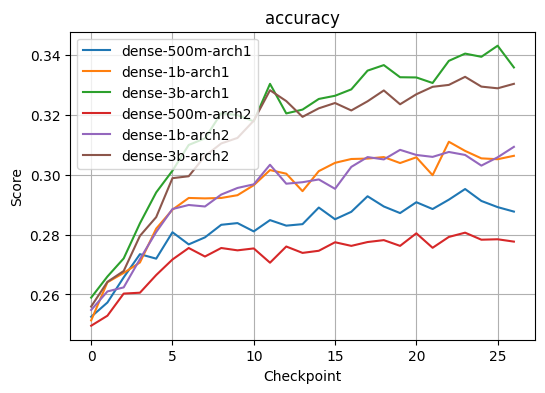

{'signal_quality': np.float64(0.890108302012292),
 'ranking_consistency': np.float64(0.8095238095238095),
 'final_score': np.float64(0.8766775532642117)}

In [57]:
eval_proc(
    accuracy,
    arc_ll,
    questions_df,
    plot=True
)

A solução que propomos é usar a diferença entre a log-likelihood da alternativa correta e a média das log-likelihoods das alternativas incorretas. Assim, se a diferença for grande, significa que o modelo está confiante na resposta correta, e se for pequena ou negativa, significa que o modelo está incerto ou errado.

In [12]:
def log_likelihood_diff(log_likelihoods: np.ndarray, target: int) -> float:
    correct_ll = log_likelihoods[target]
    other_lls = np.sum(log_likelihoods) - correct_ll
    mean_incorrect_ll = other_lls / (len(log_likelihoods) - 1)
    return correct_ll - mean_incorrect_ll

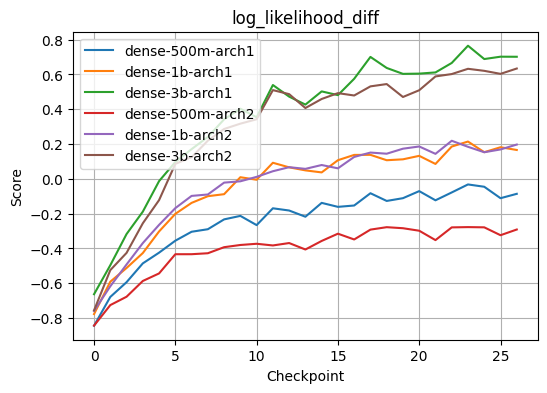

{'signal_quality': np.float64(0.9526489018694342),
 'ranking_consistency': np.float64(0.8571428571428571),
 'final_score': np.float64(0.9367312277483381)}

In [58]:
eval_proc(
    log_likelihood_diff,
    arc_ll,
    questions_df,
    plot=True
)

Algumas ideias podem ser instáveis durante o aprendizado, subindo e descendo. Por exemplo, se subtrairmos a log-likelihood máxima da mínima. Apesar de ser parecido com a solução anterior, remover o ponto fixo que é "a alternativa correta" prejudica a estabilidade.

In [13]:
def log_likelihood_diff_v2(log_likelihoods: np.ndarray, target: int) -> float:
    return np.max(log_likelihoods) - np.min(log_likelihoods)

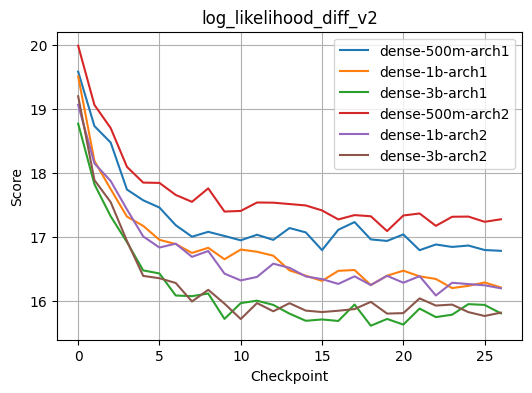

{'signal_quality': np.float64(0.4232335540836905),
 'ranking_consistency': np.float64(0.6666666666666666),
 'final_score': np.float64(0.4638057395141866)}

In [59]:
eval_proc(
    log_likelihood_diff_v2,
    arc_ll,
    questions_df,
    plot=True
)

## Avaliação de muitas métricas

In [14]:
def score_diff(
    log_likelihoods: np.ndarray,
    target: int,
    diff_space: str = "log",
    return_space: str = "log",
    agg_mode: str = "mean",
    add_mean: bool = False,
) -> float:
    if diff_space == "prob":
        scores = np.exp(log_likelihoods)
    elif diff_space == "log":
        scores = log_likelihoods

    correct_score = scores[target]
    other_scores = np.array([s for i, s in enumerate(scores) if i != target])

    if agg_mode == "mean":
        agg_other = np.mean(other_scores)
    elif agg_mode == "max":
        agg_other = np.max(other_scores)
    elif agg_mode == "min":
        agg_other = np.min(other_scores)

    score = correct_score - agg_other
    if add_mean:
        score += np.mean(scores)
    
    if return_space == "prob" and diff_space == "log":
        score = np.exp(score)
    elif return_space == "log" and diff_space == "prob":
        score = np.log(max(score, 1e-20))
    return score


dict_with_metrics = {
    "log_likelihood_diff_mean" : lambda ll, tgt: score_diff(ll, tgt, "log", "log", "mean", False),
    "log_likelihood_diff_max" : lambda ll, tgt: score_diff(ll, tgt, "log", "log", "max", False),
    "log_likelihood_diff_min" : lambda ll, tgt: score_diff(ll, tgt, "log", "log", "min", False),
    
    "log_likelihood_diff_mono_mean" : lambda ll, tgt: score_diff(ll, tgt, "log", "log", "mean", True),
    "log_likelihood_diff_mono_max" : lambda ll, tgt: score_diff(ll, tgt, "log", "log", "max", True),
    "log_likelihood_diff_mono_min" : lambda ll, tgt: score_diff(ll, tgt, "log", "log", "min", True),

    "log_likelihood_diff_prob_mean" : lambda ll, tgt: score_diff(ll, tgt, "prob", "log", "mean", False),
    "log_likelihood_diff_prob_max" : lambda ll, tgt: score_diff(ll, tgt, "prob", "log", "max", False),
    "log_likelihood_diff_prob_min" : lambda ll, tgt: score_diff(ll, tgt, "prob", "log", "min", False),
    
    "log_likelihood_diff_prob_mono_mean" : lambda ll, tgt: score_diff(ll, tgt, "prob", "log", "mean", True),
    "log_likelihood_diff_prob_mono_max" : lambda ll, tgt: score_diff(ll, tgt, "prob", "log", "max", True),
    "log_likelihood_diff_prob_mono_min" : lambda ll, tgt: score_diff(ll, tgt, "prob", "log", "min", True),
    
    "prob_diff_mean" : lambda ll, tgt: score_diff(ll, tgt, "prob", "prob", "mean", False),
    "prob_diff_max" : lambda ll, tgt: score_diff(ll, tgt, "prob", "prob", "max", False),
    "prob_diff_min" : lambda ll, tgt: score_diff(ll, tgt, "prob", "prob", "min", False),
    
    "prob_diff_mono_mean" : lambda ll, tgt: score_diff(ll, tgt, "prob", "prob", "mean", True),
    "prob_diff_mono_max" : lambda ll, tgt: score_diff(ll, tgt, "prob", "prob", "max", True),
    "prob_diff_mono_min" : lambda ll, tgt: score_diff(ll, tgt, "prob", "prob", "min", True),
}

In [160]:
results_fn = []
for name, fn in dict_with_metrics.items():
    print(f"Evaluating {name}...")
    results = eval_proc(
        fn,
        arc_ll,
        questions_df,
    )
    results_fn.append(
        {
            "metric": name,
            "signal_quality": results["signal_quality"],
            "ranking_consistency": results["ranking_consistency"],
            "final_score": results["final_score"],
        }
    )

Evaluating log_likelihood_diff_mean...
Evaluating log_likelihood_diff_max...
Evaluating log_likelihood_diff_min...
Evaluating log_likelihood_diff_mono_mean...
Evaluating log_likelihood_diff_mono_max...
Evaluating log_likelihood_diff_mono_min...
Evaluating log_likelihood_diff_prob_mean...
Evaluating log_likelihood_diff_prob_max...
Evaluating log_likelihood_diff_prob_min...
Evaluating log_likelihood_diff_prob_mono_mean...
Evaluating log_likelihood_diff_prob_mono_max...
Evaluating log_likelihood_diff_prob_mono_min...
Evaluating prob_diff_mean...
Evaluating prob_diff_max...
Evaluating prob_diff_min...
Evaluating prob_diff_mono_mean...
Evaluating prob_diff_mono_max...
Evaluating prob_diff_mono_min...


In [161]:
pd.DataFrame(results_fn).sort_values(by="final_score", ascending=False)

,metric,signal_quality,ranking_consistency,final_score
0,log_likelihood_diff_mean,0.952649,0.857143,0.936731
1,log_likelihood_diff_max,0.958568,0.682540,0.912564
10,log_likelihood_diff_prob_mono_max,0.915522,0.873016,0.908438
9,log_likelihood_diff_prob_mono_mean,0.903211,0.873016,0.898179
3,log_likelihood_diff_mono_mean,0.923601,0.730159,0.891361
8,log_likelihood_diff_prob_min,0.918048,0.714286,0.884087
7,log_likelihood_diff_prob_max,0.902876,0.777778,0.882026
6,log_likelihood_diff_prob_mean,0.906847,0.746032,0.880045
5,log_likelihood_diff_mono_min,0.908862,0.730159,0.879078
11,log_likelihood_diff_prob_mono_min,0.885701,0.777778,0.867714


## Filtragem de questões

As questões do MMLU são de diferentes níveis de dificuldade. Algumas são muito fáceis, e outras são muito difíceis. Para facilitar a análise, a função `eval_proc` agora aceita um argumento opcional `subset_questions`, que é uma lista ou array com os índices das questões a serem avaliadas. Se não for fornecido, todas as questões serão usadas.

Vamos realizar uma análise comparando scores médios de cada `subject` do MMLU.

In [52]:
# load questions and ll if not already loaded
#arc_ll = preload_results(prompt)
#questions_df = load_questions()

In [ ]:
results = []
subjects = questions_df['subject'].unique()
for subject in subjects:
    subject_questions = questions_df[questions_df['subject'] == subject].index.tolist()
    result = eval_proc(
        log_likelihood_diff,
        arc_ll,
        questions_df,
        subset_questions=subject_questions,
    )
    results.append({
        "subject": subject,
        "num_questions": len(subject_questions),
        **result
    })
results = pd.DataFrame(results)

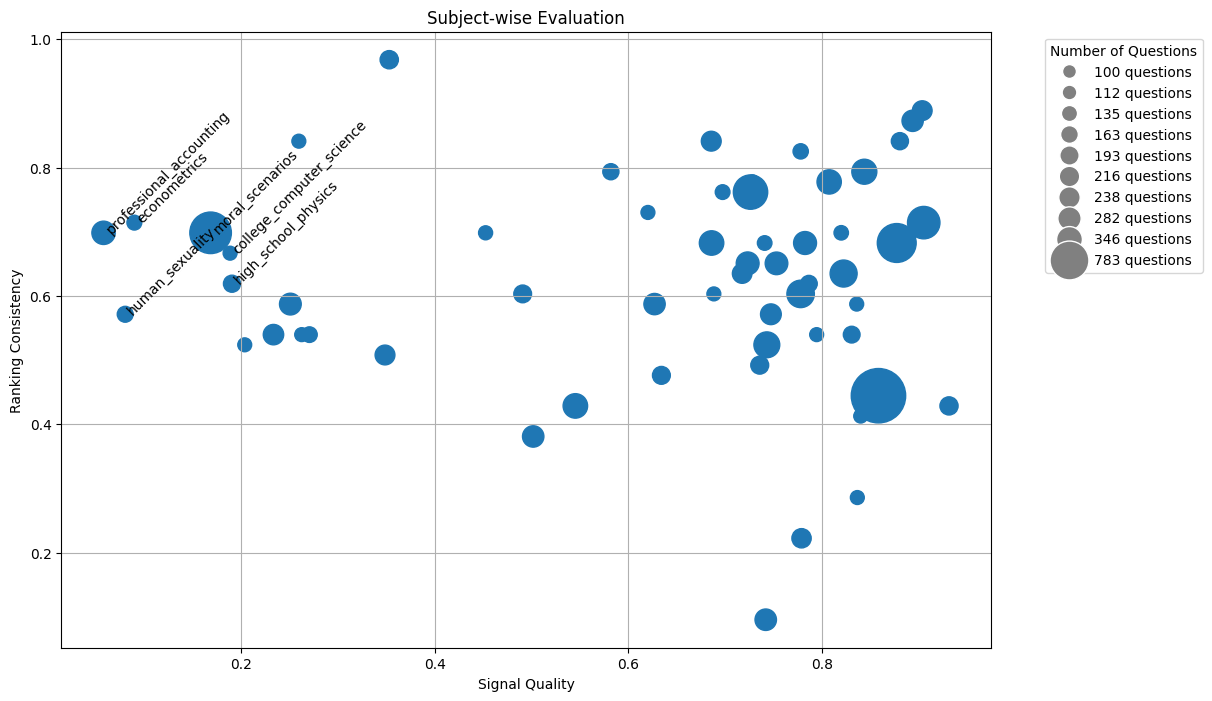

In [75]:

fig = plt.figure(figsize=(12, 8))
plt.scatter(
    results["signal_quality"],
    results["ranking_consistency"],
    s=results["num_questions"],
)
plt.xlabel("Signal Quality")
plt.ylabel("Ranking Consistency")
plt.title("Subject-wise Evaluation")
# add legend with number of questions
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=str(size) + ' questions',
                   markerfacecolor='gray', markersize=np.sqrt(size))
        for size in sorted(results["num_questions"].unique())
    ][::5],
    title="Number of Questions",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# plot the name of subjects with signal quality lower than 0.15
for i, row in results.iterrows():
    if row["signal_quality"] < 0.2:
        plt.text(row["signal_quality"], row["ranking_consistency"], row["subject"], rotation=45)
plt.grid()
plt.show()

Podemos tentar uma abordagem diferente de remover uma das "caldas" das questões. Isto é, pegamos todas menos as que tem tamanho menor do que x, ou todas menos as que tem tamanho maior do que y.

In [136]:
length_bins = np.quantile(questions_df["target_len"], [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
results = []
for i, bin_ in enumerate(length_bins):
    subset_questions = questions_df[
        (questions_df["target_len"] >= bin_)
    ].index.tolist()
    if len(subset_questions) == 0:
        continue
    result = eval_proc(
        log_likelihood_diff,
        arc_ll,
        questions_df,
        subset_questions=subset_questions,
    )
    results.append({
        "length_bin": bin_,
        "num_questions": len(subset_questions),
        **result
    })
results = pd.DataFrame(results)

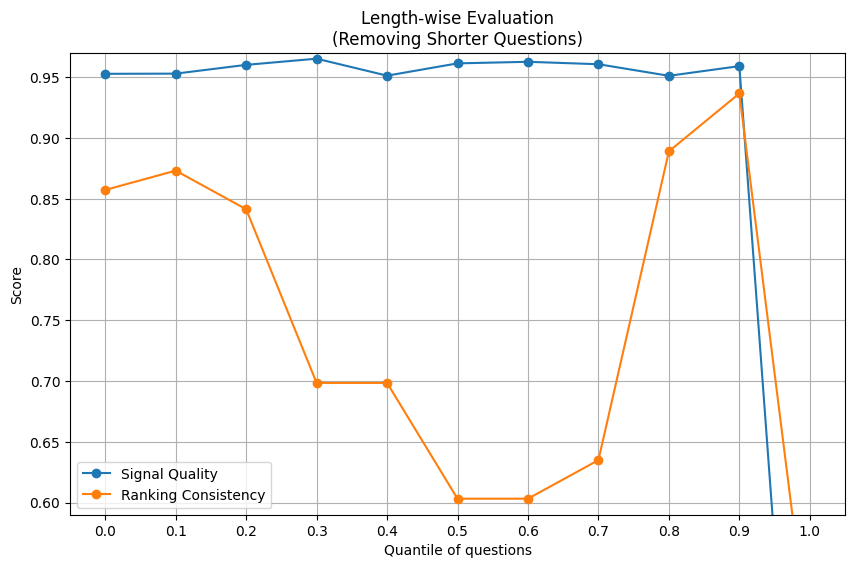

In [139]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    results["signal_quality"],
    label="Signal Quality",
    marker='o'
)
plt.plot(
    results["ranking_consistency"],
    label="Ranking Consistency",
    marker='o'
)
plt.xticks(ticks=range(len(results)), labels=[i/10 for i in range(len(results))])
plt.xlabel("Quantile of questions")
plt.ylabel("Score")
plt.title("Length-wise Evaluation\n(Removing Shorter Questions)")
plt.grid()
plt.ylim(0.59, 0.97)
plt.legend()
plt.show()

In [140]:
length_bins = np.quantile(questions_df["target_len"], [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
results = []
for i, bin_ in enumerate(length_bins):
    subset_questions = questions_df[
        (questions_df["target_len"] <= bin_)
    ].index.tolist()
    if len(subset_questions) == 0:
        continue
    result = eval_proc(
        log_likelihood_diff,
        arc_ll,
        questions_df,
        subset_questions=subset_questions,
    )
    results.append({
        "length_bin": bin_,
        "num_questions": len(subset_questions),
        **result
    })
results = pd.DataFrame(results)

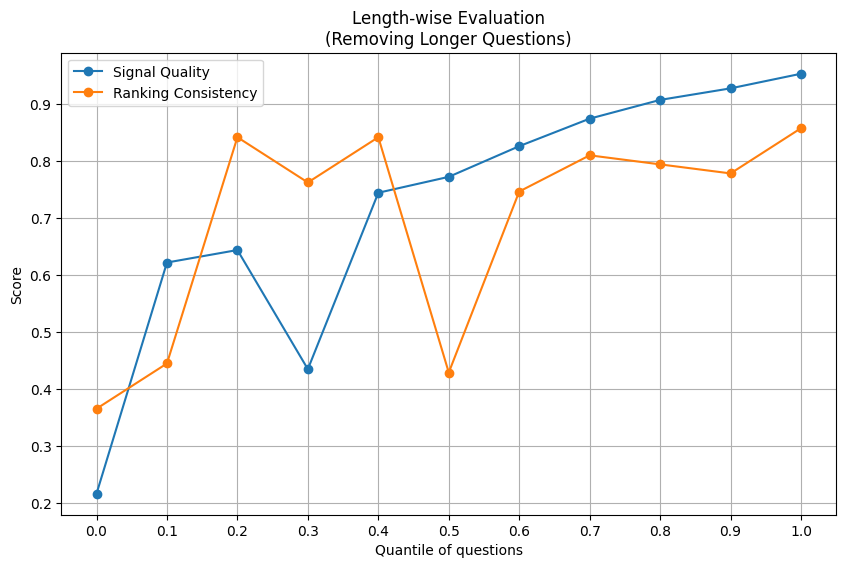

In [141]:
fig = plt.figure(figsize=(10, 6))
plt.plot(
    results["signal_quality"], label="Signal Quality", marker="o"
)
plt.plot(
    results["ranking_consistency"],
    label="Ranking Consistency",
    marker="o",
)
plt.xticks(ticks=range(len(results)), labels=[i/10 for i in range(len(results))])
plt.xlabel("Quantile of questions")
plt.ylabel("Score")
plt.title("Length-wise Evaluation\n(Removing Longer Questions)")
plt.grid()
# plot at the end "All questions"
plt.annotate(
    "All questions",
    (results["length_bin"].iloc[-1], results["signal_quality"].iloc[-1]),
    textcoords="offset points",
    xytext=(0, -10),
    ha="center",
)
plt.legend()
plt.show()

## Repetindo toda essa análise, porém com outras métricas

In [156]:
def full_filtering_analysis(
    post_process_fn: Callable,
    arc_ll: Dict[str, np.ndarray],
    questions_df: pd.DataFrame,
):  
    
    # eval by subject
    ##############
    results = []
    subjects = questions_df['subject'].unique()
    for subject in subjects:
        subject_questions = questions_df[questions_df['subject'] == subject].index.tolist()
        result = eval_proc(
            post_process_fn,
            arc_ll,
            questions_df,
            subset_questions=subject_questions,
        )
        results.append({
            "subject": subject,
            "num_questions": len(subject_questions),
            **result
        })
    results = pd.DataFrame(results)

    fig = plt.figure(figsize=(12, 8))
    plt.scatter(
        results["signal_quality"],
        results["ranking_consistency"],
        s=results["num_questions"],
    )
    plt.xlabel("Signal Quality")
    plt.ylabel("Ranking Consistency")
    plt.title("Subject-wise Evaluation")
    # add legend with number of questions
    plt.legend(
        handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=str(size) + ' questions',
                    markerfacecolor='gray', markersize=np.sqrt(size))
            for size in sorted(results["num_questions"].unique())
        ][::5],
        title="Number of Questions",
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )

    # get the 3-worst signal quality
    worst_subjects = results.nsmallest(3, "signal_quality")
    for i, row in worst_subjects.iterrows():
        plt.text(row["signal_quality"], row["ranking_consistency"], row["subject"], rotation=45)
    plt.grid()
    plt.show()


    # analysis by length
    #################
    length_bins = np.quantile(questions_df["target_len"], [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    results = []
    for i, bin_ in enumerate(length_bins):
        subset_questions = questions_df[
            (questions_df["target_len"] > bin_)
        ].index.tolist()
        if len(subset_questions) == 0:
            continue
        result = eval_proc(
            post_process_fn,
            arc_ll,
            questions_df,
            subset_questions=subset_questions,
        )
        results.append({
            "length_bin": bin_,
            "num_questions": len(subset_questions),
            **result
        })
    results = pd.DataFrame(results)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(
        results["signal_quality"],
        label="Signal Quality",
        marker='o'
    )
    plt.plot(
        results["ranking_consistency"],
        label="Ranking Consistency",
        marker='o'
    )
    plt.xticks(ticks=range(len(results)), labels=[i/10 for i in range(len(results))])
    plt.xlabel("Quantile of questions")
    plt.ylabel("Score")
    plt.title("Length-wise Evaluation\n(Removing Shorter Questions)")
    plt.grid()
    plt.ylim(0.59, 0.97)
    plt.legend()
    plt.show()

    results = []
    for i, bin_ in enumerate(length_bins):
        subset_questions = questions_df[
            (questions_df["target_len"] < bin_)
        ].index.tolist()
        if len(subset_questions) == 0:
            continue
        result = eval_proc(
            post_process_fn,
            arc_ll,
            questions_df,
            subset_questions=subset_questions,
        )
        results.append({
            "length_bin": bin_,
            "num_questions": len(subset_questions),
            **result
        })
    results = pd.DataFrame(results)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(
        results["signal_quality"], label="Signal Quality", marker="o"
    )
    plt.plot(
        results["ranking_consistency"],
        label="Ranking Consistency",
        marker="o",
    )
    plt.xticks(ticks=range(len(results)), labels=[i/10 for i in range(len(results))])
    plt.xlabel("Quantile of questions")
    plt.ylabel("Score")
    plt.title("Length-wise Evaluation\n(Removing Longer Questions)")
    plt.grid()
    # plot at the end "All questions"
    plt.annotate(
        "All questions",
        (results["length_bin"].iloc[-1], results["signal_quality"].iloc[-1]),
        textcoords="offset points",
        xytext=(0, -10),
        ha="center",
    )
    plt.legend()
    plt.show()


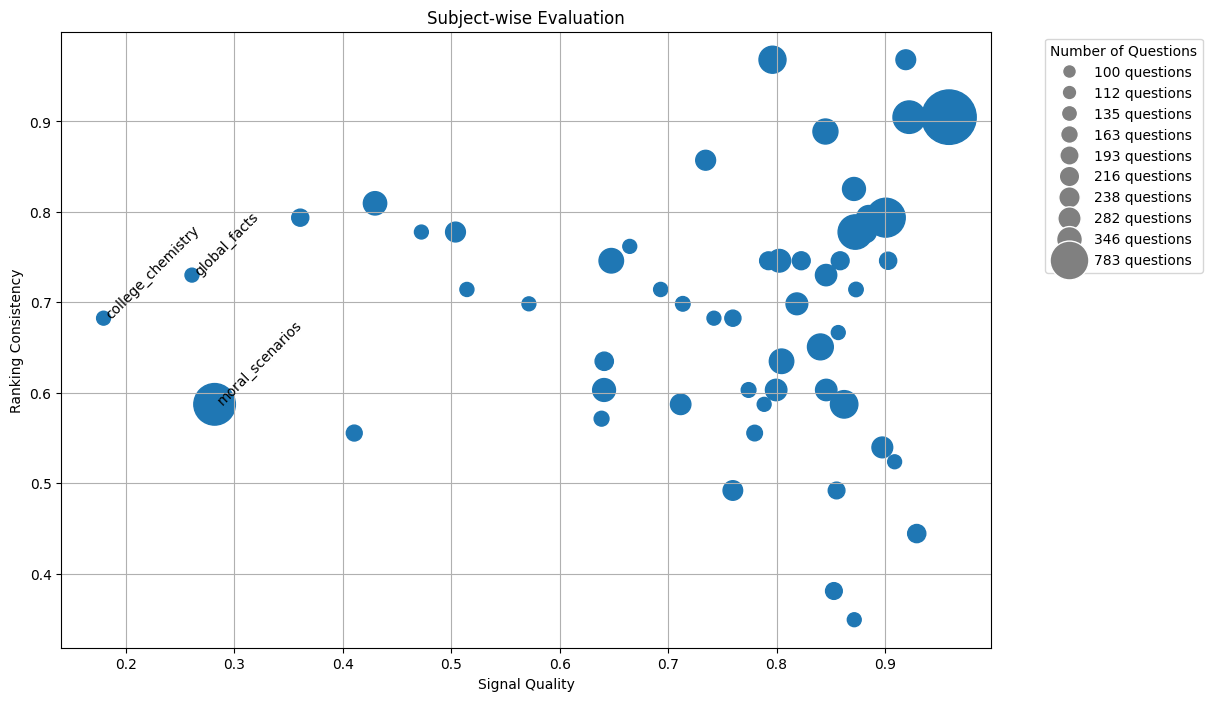

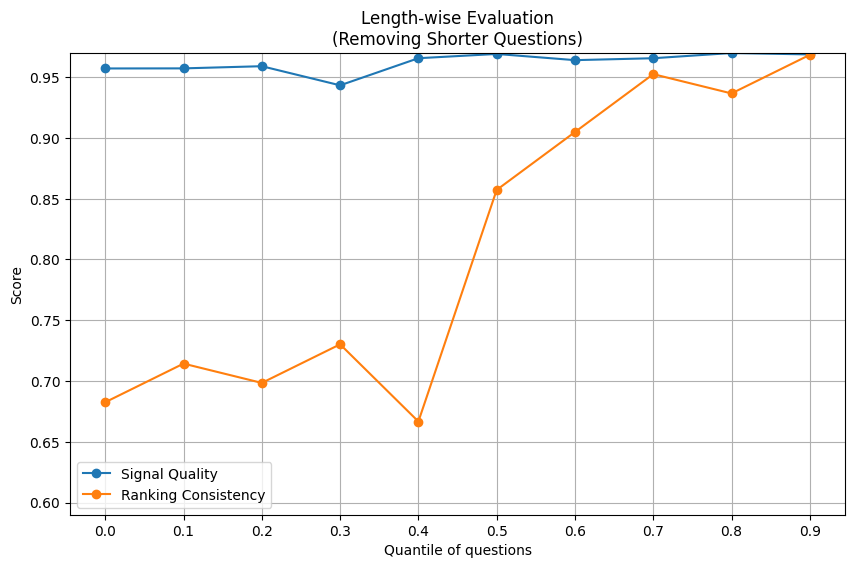

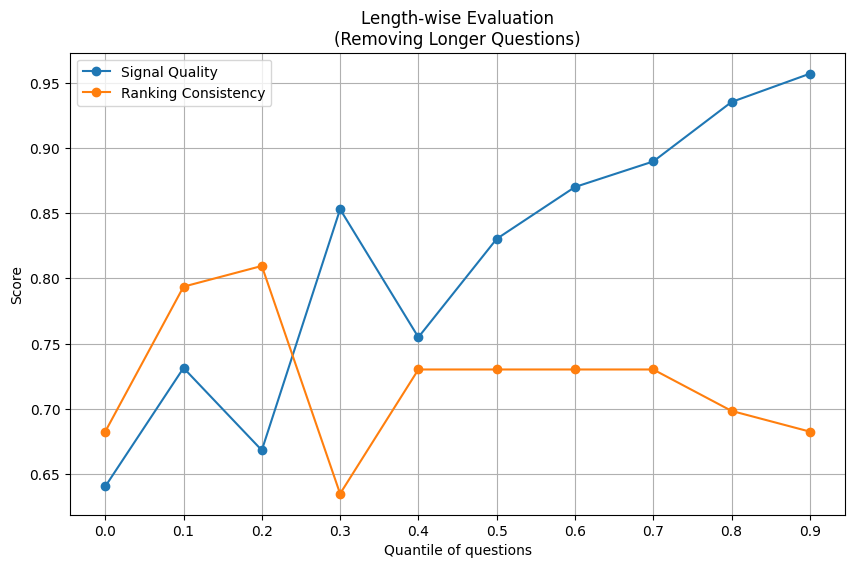

In [162]:
full_filtering_analysis(
    dict_with_metrics["log_likelihood_diff_max"],
    arc_ll,
    questions_df
)

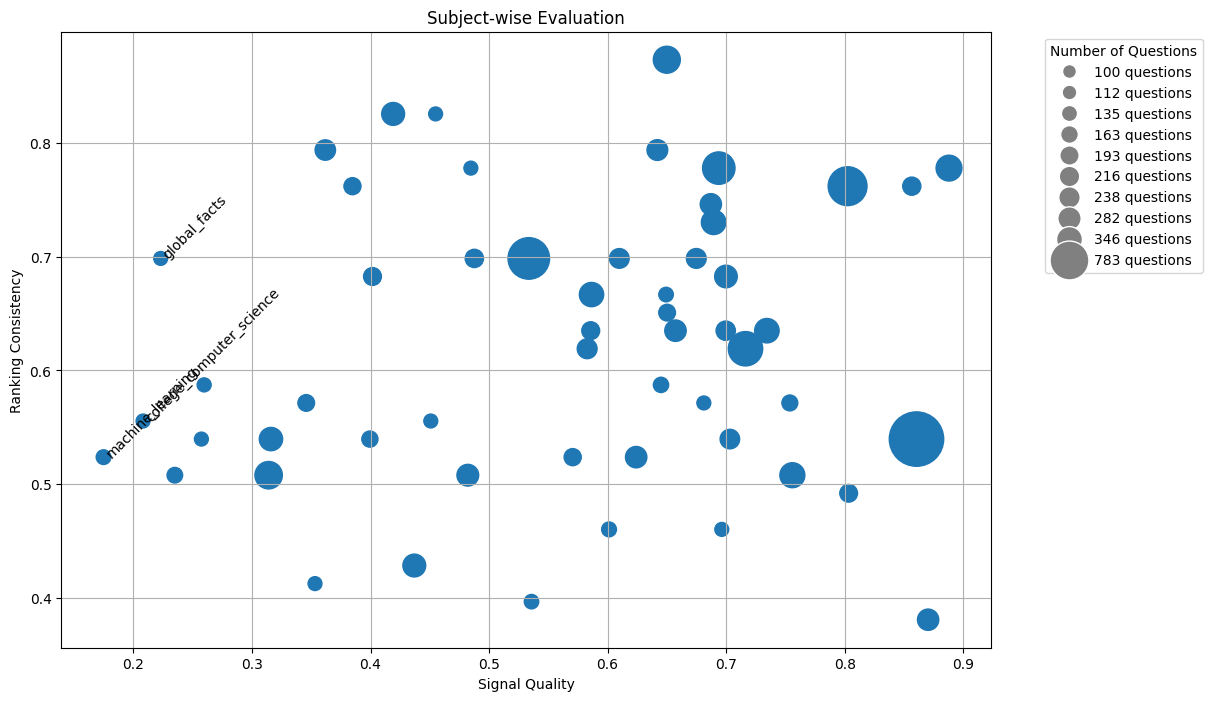

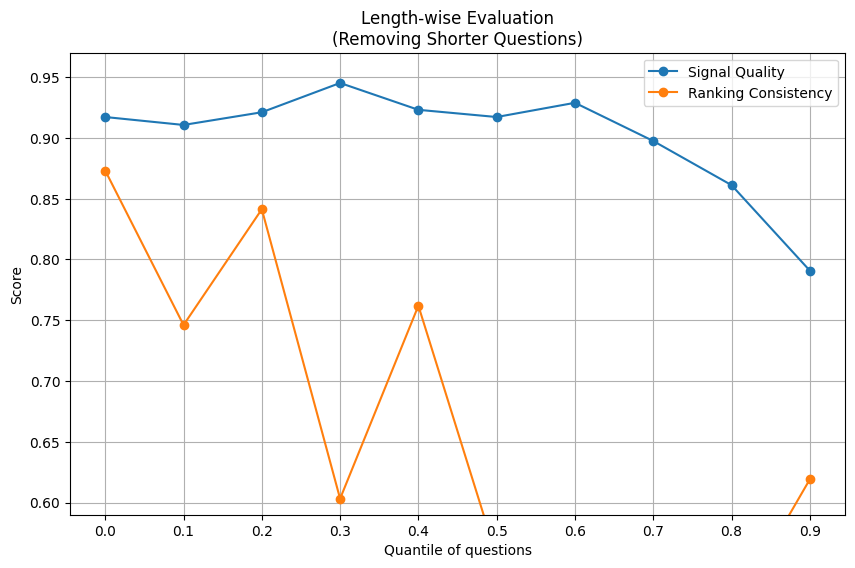

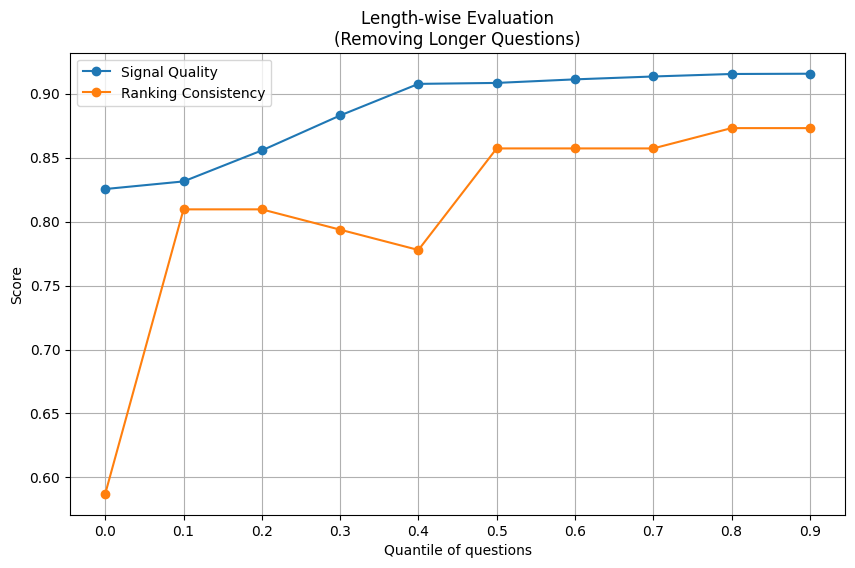

In [163]:
full_filtering_analysis(
    dict_with_metrics["log_likelihood_diff_prob_mono_max"],
    arc_ll,
    questions_df
)	

## Repetindo a análise POR questão

In [16]:
results = []
from tqdm import tqdm
for i in tqdm(range(questions_df.shape[0])):
    result = eval_proc(
        dict_with_metrics["log_likelihood_diff_max"],
        arc_ll,
        questions_df,
        subset_questions=[i],
    )
    results.append({
        "question": questions_df.iloc[i]["question"],
        "subject": questions_df.iloc[i]["subject"],
        "target": questions_df.iloc[i]["target"],
        "target_len": questions_df.iloc[i]["target_len"],
        **result
    })
results = pd.DataFrame(results)

 29%|███████████████████████████████████▏                                                                                       | 4019/14042 [00:57<02:22, 70.24it/s]/home/giovani.valdrighi/miniconda3/envs/e2lm/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/giovani.valdrighi/miniconda3/envs/e2lm/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14042/14042 [03:21<00:00, 69.63it/s]


In [26]:

results.groupby("subject").agg({"final_score" : "mean"}).sort_values(by="final_score", ascending=False)

,final_score
subject,
us_foreign_policy,0.358180
abstract_algebra,0.347826
high_school_computer_science,0.347489
formal_logic,0.345478
astronomy,0.344240
international_law,0.343779
world_religions,0.342390
jurisprudence,0.342340
computer_security,0.341243


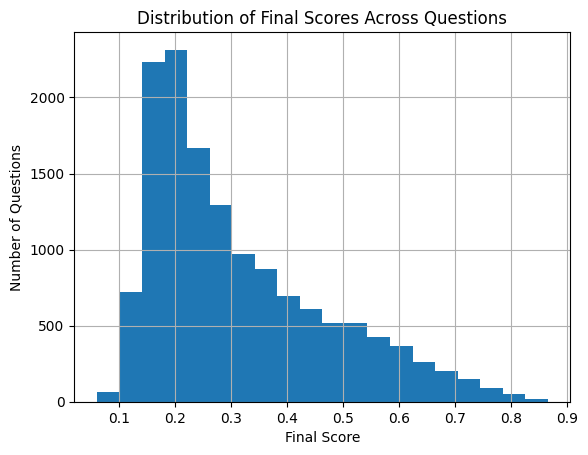

In [28]:
plt.hist(results["final_score"], bins=20)
plt.xlabel("Final Score")
plt.ylabel("Number of Questions")
plt.title("Distribution of Final Scores Across Questions")
plt.grid()
plt.show()

In [24]:
def filter_mmlu(new_dataset_name: str, selected_questions: list, hf_token: str):
    dataset = datasets.load_dataset("cais/mmlu", "all", split="test")
    dataset_dev = datasets.load_dataset("cais/mmlu", "all", split="dev")

    def add_selection(example):
        example["selected"] = example["id"] in selected_questions
        return example

    def placeholder_selection(example):
        example["selected"] = True
        return example

    # add id column to the dataset based on the index
    dataset = dataset.map(lambda example, idx: {"id": idx}, with_indices=True)
    dataset_dev = dataset_dev.map(lambda example, idx: {"id": idx}, with_indices=True)

    modified_dataset = dataset.map(add_selection)
    dataset_dev = dataset_dev.map(placeholder_selection)

    # filter the dataset to keep only examples with score > lower_threshold
    modified_dataset = modified_dataset.filter(lambda example: example["selected"])

    # push to hugging face
    modified_dataset.push_to_hub(
        f"giovanivaldrighi/{new_dataset_name}", private=True, token=hf_token
    )

    dataset_dev.push_to_hub(
        f"giovanivaldrighi/{new_dataset_name}",
        split="dev",
        private=True,
        token=hf_token,
    )

In [ ]:
selected_results = results.sort_values(by="final_score", ascending=False).head(results.shape[0]//2)
selected_results_questions = selected_results.index.tolist()
# save a json with list
with open("selected_questions.json", "w") as f:
    json.dump(selected_results_questions, f)

In [10]:
with open("selected_questions.json", "r") as f:
    selected_results_questions = json.load(f)

In [22]:
hf_token = input("Enter your HF token: ")

In [ ]:
filter_mmlu("mmlu_small_v1", selected_results_questions, hf_token)